Loaded data for 31 assets.

Solving for the optimal portfolio (Maximum Sharpe Ratio)...
Calculating the efficient frontier...

Efficient frontier plot saved as 'efficient_frontier.png'

Benchmark Results for the Optimal Portfolio
Portfolio Expected Return (OAS): 0.9017
Portfolio Risk (Volatility): 1.1713
Sharpe Ratio: 0.7699

Optimal Asset Allocation:
                Weight
isin                  
US15135BAW19  0.073489
US444859CA81  0.055621
US081437AT26  0.051432
US759351AP49  0.047180
US444859BV38  0.044594
US540424AT59  0.042572
US097023CJ22  0.040756
US444859BR26  0.039198
US444859BY76  0.037204
US020002BJ95  0.034480
US75513EAD31  0.034467
US13645RAD61  0.034211
US21871XAS80  0.034094
US655844CR73  0.033439
US443201AC21  0.032427
US36166NAK90  0.029198
US24422EWZ86  0.029054
US026874DS37  0.028550
US45687VAB27  0.027302
US14448CBC73  0.026111
US314353AA14  0.025801
US56501RAN61  0.025424
US91324PEJ75  0.022266
US13645RBF01  0.021735
US655844CT30  0.021024
US760759BA74  0.020966
US

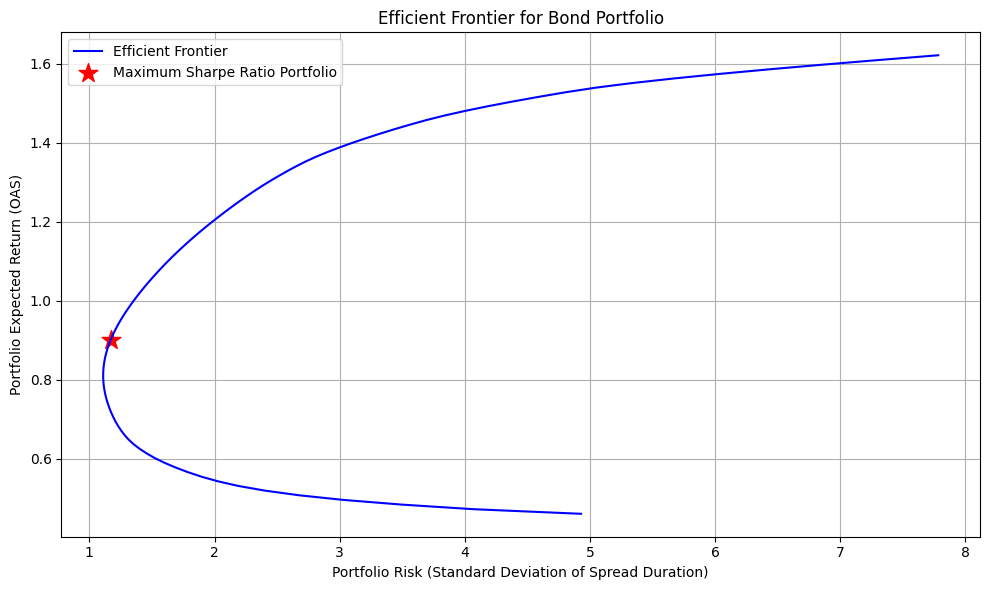

In [1]:
# =============================================================================
#
# --- Classical Portfolio Optimization using Modern Portfolio Theory ---
#
# Description:
#   This script performs a classical portfolio optimization for a universe of
#   bonds based on the principles of Modern Portfolio Theory (MPT).
#
#   The main objectives are:
#   1.  To find the single portfolio that offers the highest risk-adjusted
#       return, defined as the one maximizing the Sharpe Ratio.
#   2.  To calculate and plot the "Efficient Frontier," which represents the
#       set of optimal portfolios that offer the highest expected return for a
#       given level of risk.
#
# Required Files:
#   - assets.csv: The raw data for all bonds.
#
# Main Outputs:
#   - Console output with the benchmark results and optimal asset allocation.
#   - efficient_frontier.png: A plot of the efficient frontier.
#   - optimal_asset_allocation.csv: A CSV file with the final portfolio weights.
#
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- 1. Data Loading and Preparation ---
# -----------------------------------------
# Load the dataset and extract the necessary financial metrics for optimization.
# -----------------------------------------
try:
    df = pd.read_csv('assets.csv')
    # Using 'isin' as the unique identifier is more robust than 'issuerShortName'
    assets = df[['isin', 'oas', 'spreadDur']].copy()
    assets.set_index('isin', inplace=True)
    n_assets = len(assets)
    print(f"Loaded data for {n_assets} assets.")
except FileNotFoundError:
    print("Error: 'assets.csv' not found. Please ensure it is in the same directory.")
    exit()


# --- 2. Define Expected Returns and Risk ---
# -------------------------------------------
# We define our financial model based on the available data.
# -------------------------------------------

# 'oas' (Option-Adjusted Spread) is used as a proxy for the expected return.
# We divide by 100 to convert from basis points to a decimal representation.
mu = assets['oas'].values / 100

# 'spreadDur' (Spread Duration) is used as a proxy for the risk (volatility) of each asset.
std_devs = assets['spreadDur'].values

# Create the covariance matrix. For this baseline model, we assume asset
# returns are uncorrelated, making the covariance matrix a diagonal matrix
# of individual asset variances (std_dev^2).
Sigma = np.diag(std_devs**2)


# --- 3. Portfolio Optimization Functions ---
# -------------------------------------------
# Define the objective functions and constraints for the SciPy optimizer.
# -------------------------------------------

def portfolio_variance(weights, sigma):
    """Calculates the variance of a portfolio."""
    return weights.T @ sigma @ weights

def negative_sharpe_ratio(weights, mu, sigma, risk_free_rate):
    """Calculates the negative Sharpe Ratio for minimization."""
    port_return = weights.T @ mu
    port_volatility = np.sqrt(weights.T @ sigma @ weights)
    if port_volatility == 0:
        return 0  # Avoid division by zero
    # We negate the Sharpe Ratio because our goal is to maximize it, and the
    # SciPy `minimize` function can only minimize.
    return -(port_return - risk_free_rate) / port_volatility

# Set the risk-free rate (e.g., 0 for simplicity in this model)
risk_free_rate = 0

# Initial guess for the weights (equal allocation) for the optimizer to start
initial_weights = np.ones(n_assets) / n_assets

# --- 4. Define Constraints and Bounds ---
# ----------------------------------------
# Define the rules for a valid portfolio.
# ----------------------------------------

# The sum of all asset weights must be equal to 1 (100% of the portfolio).
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Each weight must be between 0 and 1 (no short selling allowed).
bounds = tuple((0, 1) for _ in range(n_assets))


# --- 5. Solve for the Optimal Portfolio (Maximum Sharpe Ratio) ---
# -----------------------------------------------------------------
print("\nSolving for the optimal portfolio (Maximum Sharpe Ratio)...")
optimal_portfolio = minimize(negative_sharpe_ratio,
                             initial_weights,
                             args=(mu, Sigma, risk_free_rate),
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)

# Extract the optimal weights from the optimization result
optimal_weights = optimal_portfolio.x


# --- 6. Calculate the Efficient Frontier ---
# -------------------------------------------
# To visualize the trade-off between risk and return, we calculate the
# portfolio with the minimum risk for a range of possible target returns.
# -------------------------------------------
print("Calculating the efficient frontier...")
target_returns = np.linspace(mu.min(), mu.max(), 100)
portfolio_risks = []

for target_return in target_returns:
    constraints_frontier = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                            {'type': 'eq', 'fun': lambda weights: weights.T @ mu - target_return})
    
    # Find the portfolio with the minimum variance for the given target return
    frontier_portfolio = minimize(portfolio_variance,
                                  initial_weights,
                                  args=(Sigma,),
                                  method='SLSQP',
                                  bounds=bounds,
                                  constraints=constraints_frontier)
    
    if frontier_portfolio.success:
        portfolio_risks.append(np.sqrt(frontier_portfolio.fun))
    else:
        portfolio_risks.append(np.nan) # Mark as NaN if no solution found


# --- 7. Prepare and Display the Results ---
# ------------------------------------------
# Calculate the final metrics for the optimal portfolio and generate outputs.
# ------------------------------------------

# Calculate the final return, risk, and Sharpe ratio of the optimal portfolio
optimal_return = optimal_weights.T @ mu
optimal_risk = np.sqrt(optimal_weights.T @ Sigma @ optimal_weights)
optimal_sharpe = (optimal_return - risk_free_rate) / optimal_risk

# Create a DataFrame for the optimal asset allocation
optimal_allocation = pd.DataFrame({'Weight': optimal_weights}, index=assets.index)
# Filter out assets with very small weights for cleaner output
optimal_allocation = optimal_allocation[optimal_allocation['Weight'] > 1e-4]
optimal_allocation.sort_values(by='Weight', ascending=False, inplace=True)

# --- 8. Plot the Efficient Frontier ---
plt.figure(figsize=(10, 6))
# Filter out any NaN values for a clean plot
valid_returns = np.array(target_returns)[~np.isnan(portfolio_risks)]
valid_risks = np.array(portfolio_risks)[~np.isnan(portfolio_risks)]

plt.plot(valid_risks, valid_returns, 'b-', label='Efficient Frontier')
plt.scatter(optimal_risk, optimal_return, c='red', marker='*', s=200, label='Maximum Sharpe Ratio Portfolio')
plt.title('Efficient Frontier for Bond Portfolio')
plt.xlabel('Portfolio Risk (Standard Deviation of Spread Duration)')
plt.ylabel('Portfolio Expected Return (OAS)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot to a file
plt.savefig('efficient_frontier.png')
print("\nEfficient frontier plot saved as 'efficient_frontier.png'")

# --- 9. Print Benchmark Results to the Console ---
print("\n" + "="*50)
print("Benchmark Results for the Optimal Portfolio")
print("="*50)
print(f"Portfolio Expected Return (OAS): {optimal_return:.4f}")
print(f"Portfolio Risk (Volatility): {optimal_risk:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe:.4f}")
print("\nOptimal Asset Allocation:")
print(optimal_allocation)

# --- 10. Save the Optimal Allocation to a CSV File ---
optimal_allocation.to_csv('optimal_asset_allocation.csv')
print("\nOptimal asset allocation saved to 'optimal_asset_allocation.csv'")